In [304]:
import numpy as np 
import pandas as pd 

In [305]:
#students = pd.read_csv("students.csv")
exams = pd.read_csv("exams_gla.csv")
enrolments = pd.read_csv("enrolments_gla.csv")
rooms = pd.read_csv("rooms.csv")
slots= pd.read_csv("slots.csv")

In [306]:
class Exam:
    def __init__(self, code, duration):
        self.code = code
        self.duration = duration
        self.conflicts = 0
        self.exam_conflicts = set()
        self.priority = 0
        self.slot = -1
        self.student_codes = []
        self.students = []
        self.rooms = []
        self.room_assigned = False
        self.disability_requirement = False
        self.students_disabled = []
        self.students_assigned = 0

class Student:
    def __init__(self, student_code, disability):
        self.code = student_code
        self.disability = disability
        self.exams = []
        self.exam_codes = []

class Enrolment:
    def __init__(self, student_code, exam_code, disability):
        self.student_code = student_code
        self.exam_code = exam_code
        self.disability = disability

class Room:
    def __init__(self, room_code, capacity, disabled_suitability):
        self.code = room_code
        self.capacity = capacity
        self.status = False
        self.disabled_suitability = disabled_suitability
        self.seats_occupied = 0
        self.seats_remaining = capacity
class Slot:
    def __init__(self, index, date, day, type):
        self.index = index
        self.date = date
        self.day = day
        self.type = type
        self.exams = []
        self.student_count = 0
class RoomSlotMap:
    def __init__(self, slot, room, exams, capacity):
        self.slot = slot
        self.room = room
        self.capacity = capacity
        self.exams = exams

In [307]:
exam_objects = [Exam(**kwargs) for kwargs in exams.to_dict(orient='records')]

#student_objects = [Student(**kwargs) for kwargs in students.to_dict(orient='records')]

enrolment_objects = [Enrolment(**kwargs) for kwargs in enrolments.to_dict(orient='records')]

room_objects = [Room(**kwargs) for kwargs in rooms.to_dict(orient='records')]

slot_objects = [Slot(**kwargs) for kwargs in slots.to_dict(orient='records')]

In [308]:
student_codes = set()
for i in enrolment_objects:
    student_codes.add((i.student_code, i.disability))
    for j in exam_objects:
        if j.code == i.exam_code:
            j.student_codes.append(i.student_code)

In [309]:
student_objects= []
for i in student_codes:
    student_objects.append(Student(list(i)[0], list(i)[1]))

In [310]:
for i in exam_objects:
    for j in student_objects:
        for k in i.student_codes:
            if k == j.code:
                i.students.append(j)
                #j.exams.append(i)

In [311]:
for i in student_objects:
    for j in enrolment_objects:
        if i.code == j.student_code:
            i.exam_codes.append(j.exam_code)

In [312]:
for i in student_objects:
    for j in exam_objects:
        for k in i.exam_codes:
            if k == j.code:
                i.exams.append(j)

In [313]:
for i in exam_objects:
    for j in i.students:
        if j.disability == True:
            i.disability_requirement = True
            i.students_disabled.append(j)

In [314]:
def getRoomKey(obj):
    return obj.capacity

In [315]:
def degreeOfConflict(exam):
    s = set()
    for i in exam.students:
        for j in i.exams:
            if exam.code != j.code:
                s.add(j)
    exam.exam_conflicts = s
    return len(s)

In [316]:
for i in exam_objects:
    i.conflicts = degreeOfConflict(i)

In [317]:
examArr = []
for i in exam_objects:
    examArr.append([i.code, len(i.students)])
df = pd.DataFrame(examArr, columns=["code", "students"])

In [318]:
df.sort_values("students")

,code,students
418,LATIN5001_1 - Intermediate Latin For PGT 1,1
413,PHYS5051_1 - Groups & Symmetries Dec Exam,1
405,GREEK4003_1 - Basic Greek for Honours 1,1
412,CHEM2007_1 - Organic Chem for Visit Studs 1,1
403,GREEK5003_1 - Basic Greek for Postgrads 1,1
...,...,...
65,PHIL1010_1 - Philosophy 1A,581
50,BIOL2039_1 - Fundamental Topics in Biol 2X,592
0,MATHS1017_1 - Mathematics 1,663
66,PSYCH1001_1 - Psychology 1A,693


In [319]:
def partialExamOrdering():
    sup = np.zeros(len(exam_objects))
    for i in range(len(exam_objects)):
        for j in range(len(exam_objects)):
            if exam_objects[i].conflicts > exam_objects[j].conflicts:
                sup[i] = sup[i] + 1
                continue
            elif exam_objects[i].conflicts < exam_objects[j].conflicts:
                sup[j] = sup[j] + 1
                continue
            if len(exam_objects[i].students) > len(exam_objects[j].students):
                sup[i] = sup[i] + 1
                continue
            elif len(exam_objects[i].students) < len(exam_objects[j].students):
                sup[j] = sup[j] + 1
                continue
            if exam_objects[i].duration > exam_objects[j].duration:
                sup[i] = sup[i] + 1
                continue
            elif exam_objects[i].duration < exam_objects[j].duration:
                sup[j] = sup[j] + 1
                continue
            if len(exam_objects[i].students_disabled) > len(exam_objects[j].students_disabled):
                sup[i] = sup[i] + 1
                continue
            elif len(exam_objects[i].students_disabled) < len(exam_objects[j].students_disabled):
                sup[j] = sup[j] + 1
                continue
            if exam_objects[i].code > exam_objects[j].code:
                sup[j] = sup[j] + 1
                continue
            elif exam_objects[i].code < exam_objects[j].code:
                sup[i] = sup[i] + 1
                continue
    return sup                               

In [320]:
def totalConflictsForExams():
    partialExamOrder = partialExamOrdering()
    for i in range(len(exam_objects)):
        exam_objects[i].priority = partialExamOrder[i]  

In [321]:
def getKey(obj):
    return obj.priority

In [322]:
pheromoneMatrix = np.zeros((len(exam_objects), len(slot_objects), len(room_objects)))

def updatePheromoneMatrix(t_min, t_max, EVAPORATION_RATE):
    for i in range(len(exam_objects)):
        for j in range(len(slot_objects)):
            for k in range(len(room_objects)):
                if exam_objects[i].slot.index == slot_objects[j].index and room_objects[k] in exam_objects[i].rooms:
                    pheromoneMatrix[i][j][k] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j][k] + 1
                else:
                    pheromoneMatrix[i][j][k] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j][k]
                if pheromoneMatrix[i][j][k] < t_min:
                    pheromoneMatrix[i][j][k] = t_min
                elif pheromoneMatrix[i][j][k] > t_max:
                    pheromoneMatrix[i][j][k] = t_max
    
def initPheromoneMatrix(exams, slots, rooms, value):
    for i in range(len(exams)):
        for j in range(len(slots)):
            for k in range(len(rooms)):
                pheromoneMatrix[i][j][k] = value
       

In [323]:
heuristicsMatrix = np.zeros((len(exam_objects), len(slot_objects), len(room_objects)))

def initHeuristicsMatrix(exams, slots, rooms):
    for i in range(len(exams)):
        for j in range(len(slots)):
            for k in range(len(rooms)):
                heuristicsMatrix[i][j][k] = 1


In [324]:
def checkForHardConstraintViolations(exam, slot, room):
    score = 0
    for i in exam.exam_conflicts:
            if i.slot != -1:
                if i.slot.index == slot.index:
                    score += 4
                elif np.abs(i.slot.index - slot.index) < 2:
                    score += 4
    if slot.index == 12:
        score += 4
    if slot.index % 3 == 0 and exam.duration > 90:
        score += 4
    if len(exam.students) + slot.student_count > 2653:
        score += 4
    return score
                    

In [325]:
def numIncentive(exam, slot, room):
    score = 0
    if slot.index % 3 == 0 and exam.duration <= 90:
        score += 4
    return score

In [326]:
def checkForSoftConstraintViolations(exam, slot, room):
    score = 0
    for i in exam.exam_conflicts:
        if i.slot != -1:
            if np.abs(i.slot.index - slot.index) < 3:
                score += 1
    return score

In [327]:
def findForbiddenSlots(exam):
    forbiddenSlots = set()
    forbiddenSlots.add(slot_objects[11])
    for i in exam.exam_conflicts:
        if i.slot != -1 and i.code != exam.code:
            forbiddenSlots.add(i.slot)
    return forbiddenSlots

In [328]:
def numAdditionalViolations(exam, slot, room):
    score = 0
    score += checkForHardConstraintViolations(exam, slot, room)
    score += checkForSoftConstraintViolations(exam, slot, room)
    return score

In [329]:
def pheroHeuristicSummation(examIndex, slotIndex, roomIndex, alpha, beta):
    sum = 0
    for j in range(len(slot_objects)):
        for k in range(len(room_objects)):
            if j != slotIndex and k != roomIndex:
                sum += (pheromoneMatrix[examIndex][j][k]**alpha) * (heuristicsMatrix[examIndex][j][k]**beta)
    return sum

In [330]:
x = np.array([[1,2,5,0],[5,7,2,3]])
argList = np.flip(np.dstack(np.unravel_index(np.argsort(x.ravel()), x.shape))[0])
np.unravel_index(x.argmax(), x.shape)[0], argList

(1,
 array([[1, 1],
        [0, 1],
        [2, 0],
        [3, 1],
        [2, 1],
        [1, 0],
        [0, 0],
        [3, 0]], dtype=int64))

In [331]:
x= np.zeros((5, 6))
for i in range(5):
        for k in range(6):
            x[i][k] = np.random.randint(0,9)
x

array([[5., 0., 4., 7., 1., 4.],
       [6., 4., 1., 4., 5., 7.],
       [5., 3., 8., 7., 3., 0.],
       [5., 8., 5., 3., 4., 7.],
       [3., 4., 8., 3., 0., 0.]])

In [332]:
argList = np.flip(np.dstack(np.unravel_index(np.argsort(x.ravel()), x.shape))[0])
argList[0][1]

2

In [333]:
def chooseSlot(examIndex, exam, slots, rooms, alpha, beta):
    slot = 0
    room = []
    desirability = np.zeros((len(slots), len(rooms)))
    forbiddenSlots = list(findForbiddenSlots(exam))
    for i in range(len(slots)):
        for k in range(len(rooms)):
            #print(str(i) + ", " + str(k))
            heuristicsMatrix[examIndex][i][k] = (1 + numIncentive(exam, slots[i], rooms[k])) / (1 + numAdditionalViolations(exam, slots[i], rooms[k]))
            #print(str(heuristicsMatrix[examIndex][i][k]))
            desirability[i][k] = ((pheromoneMatrix[examIndex][i][k]**alpha) * (heuristicsMatrix[examIndex][i][k]**beta))/pheroHeuristicSummation(examIndex, slots[i], rooms[k], alpha, beta)
            for j in forbiddenSlots:
                if slot_objects[i].index == j.index:
                    desirability[i][k] = -1
                    continue
            argSortedList = np.flip(np.dstack(np.unravel_index(np.argsort(desirability.ravel()), desirability.shape))[0])
            #print("Length: " + str(argSortedList[0]))
            slot = argSortedList[0][1]
            ind = 0
            while exam.students_assigned < len(exam.students) and ind < len(argSortedList):
                room.append(rooms[argSortedList[ind][0]])
                if len(exam.students) - exam.students_assigned > rooms[argSortedList[ind][0]].capacity:
                    rooms[argSortedList[ind][0]].seats_remaining -= (len(exam.students) - exam.students_assigned)
                    exam.students_assigned += rooms[argSortedList[ind][0]].capacity
                elif len(exam.students) - exam.students_assigned < rooms[argSortedList[ind][0]].capacity:
                    exam.students_assigned += len(exam.students) - exam.students_assigned
                    rooms[argSortedList[ind][0]].seats_remaining -= exam.students_assigned
                ind += 1
    print(exam.code + ": || $lot:" + str(slots[slot].index) + ": || students: " + str(len(exam.students)) + " ||Rooms: " + str(len(room)))
    return slots[slot], room

In [334]:
def evaluateHardConstraints():
    countHard = 0
    examsChecked = []
    index = 0
    for i in slot_objects:
        if i.student_count > 2653:
            countHard += 1
    for i in room_objects:
        if i.seats_occupied > i.capacity or i.capacity - i.seats_remaining < 0:
            countHard += 1
    while index < len(exam_objects):
        exam = exam_objects[index]
        flag = False
        for j in exam.exam_conflicts:
            for k in examsChecked:
                if k == j:
                    flag = True
            if flag:
                continue
            else:
                if exam.slot.index == j.slot.index:
                        countHard += 1
                elif np.abs(exam.slot.index - j.slot.index) < 2:
                    countHard += 1
        if exam.slot.index == 12:
            countHard += 1
        if exam.slot.index % 3 == 0 and exam.duration > 90:
            countHard += 1
        index += 1
        examsChecked.append(exam)
    return countHard

In [335]:
def evaluateSoftConstraints():
    countSoft = 0
    examsChecked = []
    index = 0
    while index  < len(exam_objects):
        exam = exam_objects[index]
        flag = False
        for j in exam.exam_conflicts:
            for k in examsChecked:
                if  k == j:
                    flag = True
            if flag:
                continue
            else:
                if np.abs(exam.slot.index - j.slot.index) < 3:
                    countSoft += 1
        index += 1
        examsChecked.append(exam)
    return countSoft

In [336]:
def evaluate():
    metricHardConstraints = 0
    metricSoftConstraints = 0
    metricHardConstraints += evaluateHardConstraints()
    metricSoftConstraints += evaluateSoftConstraints()
    return metricSoftConstraints, metricHardConstraints

In [337]:
def getMapKey(obj):
    return obj.capacity

In [338]:
room_max_capacity = room_objects[0]
for i in room_objects:
    if room_max_capacity.capacity < i.capacity:
        room_max_capacity = i

In [339]:
def assignSlotsForSolution(solution):
    for i in slot_objects:
        i.exams = []
        i.student_count = 0
    for i in exam_objects:
        i.rooms = []
    for i in solution:
        list(i)[0].slot = list(i)[1]
        list(i)[0].rooms.append(list(i)[2])
        list(i)[1].exams.append(list(i)[0])
        list(i)[1].student_count += len(list(i)[0].students)
        #list(i)[2].seats_occupied += len(list(i)[0].students)

In [340]:
EVAPORATION_RATE = 0.2
numAnts = 3
t_max = 5.0
t_min = 0.0019
MAX_ITER = 10
alpha = 1.0
beta = 2.0

In [341]:
index = 0
initPheromoneMatrix(exam_objects, slot_objects, room_objects, t_max)
initHeuristicsMatrix(exam_objects, slot_objects, room_objects)
totalConflictsForExams()
#sortedExamsByPriority = sorted(exam_objects, key=getKey, reverse=True)
evaluationSoftMap = []
evaluationHardMap = []
A_gb = set()
prevScore = 0
while index < MAX_ITER:
    A_ib = set()
    prevScoreAnt = 0
    #initHeuristicsMatrix(exam_objects, slot_objects, room_objects)
    for k in range(numAnts):
        initHeuristicsMatrix(exams, slot_objects, room_objects)
        A = set()
        chosenSlot = 0
        for i in range(len(exam_objects)):
            exam_objects[i].slot = -1
            exam_objects[i].room = []
            exam_objects[i].students_assigned = 0
        for i in slot_objects:
            i.student_count = 0
        for i in room_objects:
            i.seats_occupied = 0
            i.seats_remaining = i.capacity
        for i in range(len(exam_objects)):
            chosenSlot = chooseSlot(i,exam_objects[i], slot_objects, room_objects, alpha, beta)
            exam_objects[i].slot = chosenSlot[0]
            exam_objects[i].rooms.append(chosenSlot[1])
            chosenSlot[0].student_count += len(exam_objects[i].students)
            A.add((exam_objects[i], chosenSlot[0], tuple(chosenSlot[1])))
        print("------------------------------END ANT ITER--------------------------------")
        assignSlotsForSolution(A)
        scoreAl = evaluate()[0] *4 + evaluate()[1]
        if A_ib != set():
            A_ib = A if scoreAl < prevScoreAnt else A_ib
            prevScoreAnt = scoreAl if scoreAl < prevScoreAnt else prevScoreAnt
        else:
            A_ib = A
            prevScoreAnt = scoreAl
    assignSlotsForSolution(A_ib)
    scoreA_ibl = evaluate()[0]*4 + evaluate()[1]
    if A_gb != set():
        A_gb = A_ib if scoreA_ibl < prevScore else A_gb
        prevScore = scoreA_ibl if scoreA_ibl < prevScore else prevScore
    else:
        A_gb = A_ib
        prevScore = scoreA_ibl
    assignSlotsForSolution(A_gb)
    updatePheromoneMatrix(t_min, t_max, EVAPORATION_RATE)
    evaluationSoftMap.append((index, evaluate()[0]))
    evaluationHardMap.append((index, evaluate()[1]))
    print("---|||Iteration :" + str(index) + " complete.|||---")
    index += 1

MATHS1017_1 - Mathematics 1: || $lot:3: || students: 663 ||Rooms: 10
ECON1001_1 - Economics 1A: || $lot:25: || students: 529 ||Rooms: 10
STATS1002_1 - Statistics 1Y: || $lot:22: || students: 245 ||Rooms: 10
LAW5015_1 - Corporate Governance: || $lot:19: || students: 164 ||Rooms: 7
LAW5197_1 - Corporate Finance: || $lot:16: || students: 77 ||Rooms: 3
LAW5042_1 - International Financial Reg: || $lot:13: || students: 54 ||Rooms: 3
COMPSCI1016_1 - Computing Science _ 1CT: || $lot:10: || students: 156 ||Rooms: 6
ASTRO1003_1 - Exploring the Cosmos 1X: || $lot:7: || students: 290 ||Rooms: 10
ECON5012_1 - Financial Services: || $lot:27: || students: 231 ||Rooms: 10
MGT5182_1 - Intl Strategic Mgmt: || $lot:1: || students: 308 ||Rooms: 10
ENG4179_1 - Thermal Engineering 4: || $lot:26: || students: 133 ||Rooms: 1
ENG5096_1 - Advanced Manufacture: || $lot:5: || students: 103 ||Rooms: 1
ENG5053_1 - Mech of Solids & Structures: || $lot:23: || students: 40 ||Rooms: 1
MGT5263_1 - Entrepreneurial Fin fo

KeyboardInterrupt: 

In [ ]:
prevScore

6907

<AxesSubplot:xlabel='Iterations'>

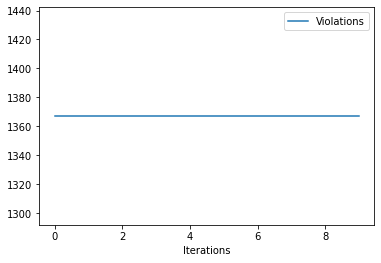

In [ ]:
evalHardDF = pd.DataFrame(evaluationHardMap, columns=['Iterations', 'Violations'])
evalHardDF.plot.line(x='Iterations', y='Violations')

<AxesSubplot:xlabel='Iterations'>

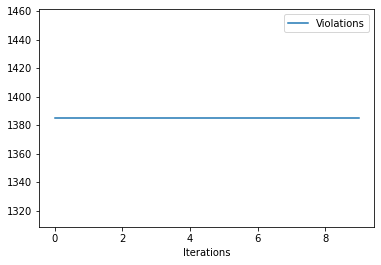

In [ ]:
evalSoftDF = pd.DataFrame(evaluationSoftMap, columns=['Iterations', 'Violations'])
evalSoftDF.plot.line(x='Iterations', y='Violations')

In [ ]:
studentArr = []
for i in student_objects:
    for j in i.exams:
        studentArr.append([i.code, j.code, j.slot.index, j.slot.day, j.slot.type, j.duration, len(j.students), j.room.code, j.room.capacity])

AttributeError: 'list' object has no attribute 'code'

In [ ]:
pd.DataFrame(studentArr).to_csv('student_output_1.csv')

In [ ]:
slotsUsed = set()
for i in slot_objects:
    examsAtslot = []
    print("Slot: " + str(i.index))
    for j in exam_objects:
        if i.index == j.slot.index:
            #print(j.code)
            examsAtslot.append([i.index, j.code, str(len(j.exam_conflicts))])
    print(len(examsAtslot))

Slot: 1
1
Slot: 2
2
Slot: 3
1
Slot: 4
1
Slot: 5
1
Slot: 6
1
Slot: 7
1
Slot: 8
1
Slot: 9
2
Slot: 10
1
Slot: 11
3
Slot: 12
0
Slot: 13
1
Slot: 14
1
Slot: 15
1
Slot: 16
1
Slot: 17
2
Slot: 18
2
Slot: 19
1
Slot: 20
1
Slot: 21
2
Slot: 22
1
Slot: 23
1
Slot: 24
2
Slot: 25
2
Slot: 26
1
Slot: 27
385


In [ ]:
longExams = []
shortExams = []
for i in exam_objects:
    if i.duration > 90:
        longExams.append(i)
    else:
        shortExams.append(i)

In [ ]:
len(longExams), len(shortExams)

(195, 224)

In [348]:
for i in exam_objects:
    print(i.code+ " : "+str(i.conflicts) + " : " + str(len(i.exam_conflicts)))

MATHS1017_1 - Mathematics 1 : 417 : 417
ECON1001_1 - Economics 1A : 414 : 414
STATS1002_1 - Statistics 1Y : 410 : 410
LAW5015_1 - Corporate Governance : 412 : 412
LAW5197_1 - Corporate Finance : 402 : 402
LAW5042_1 - International Financial Reg : 390 : 390
COMPSCI1016_1 - Computing Science _ 1CT : 402 : 402
ASTRO1003_1 - Exploring the Cosmos 1X : 410 : 410
ECON5012_1 - Financial Services : 410 : 410
MGT5182_1 - Intl Strategic Mgmt : 414 : 414
ENG4179_1 - Thermal Engineering 4 : 405 : 405
ENG5096_1 - Advanced Manufacture : 401 : 401
ENG5053_1 - Mech of Solids & Structures : 376 : 376
MGT5263_1 - Entrepreneurial Fin for SMEs : 396 : 396
COMPSCI5100_1 - Machine Learning & AI for DS : 411 : 411
ENG5062_1 - Navigation Systems M : 411 : 411
ENG5022_1 - Control M : 408 : 408
ENG5292_1 - Power Electronics and Drives M : 394 : 394
MED4042_1 - Immunology (intercal) : 310 : 310
MED4039_1 - Core Course (intercal) : 409 : 409
DENT3021_1 - Dental Stats (intercal) : 381 : 381
CHEM1001_1 - Chemistry 1

In [347]:
for i in exam_objects:
    print(str(len(i.students)))

663
529
245
164
77
54
156
290
231
308
133
103
40
69
190
177
172
91
10
102
35
571
754
55
131
93
301
263
42
132
130
130
162
14
332
237
246
238
411
234
438
444
16
132
123
128
91
244
356
389
592
325
404
474
77
216
155
24
56
474
211
443
454
418
65
581
693
173
60
225
224
267
539
452
464
55
56
55
56
56
92
73
241
72
156
117
90
111
370
73
80
16
16
159
94
111
437
5
228
316
74
281
309
298
81
329
228
70
259
217
262
213
226
212
193
79
89
74
60
166
189
102
112
246
227
265
39
40
132
91
497
32
32
19
20
20
23
256
254
72
77
147
218
319
56
113
317
317
113
165
126
26
75
321
53
49
43
34
81
55
409
42
2
2
4
4
3
2
5
27
64
118
56
57
85
50
51
51
85
51
92
86
85
48
86
15
147
162
160
256
116
51
171
141
32
119
17
139
266
107
61
164
56
274
84
64
93
60
113
260
98
391
25
28
33
115
38
47
48
44
45
32
153
55
92
6
29
9
100
129
124
21
25
104
46
61
14
24
112
66
1
1
2
1
2
98
13
10
143
142
8
67
137
149
103
26
151
139
163
241
11
72
16
40
33
33
139
139
43
20
12
137
37
58
152
27
11
11
42
36
53
312
54
179
114
46
78
82
26
70
181
6